In [17]:
# Generator V2
# Imports
import torch
import torch.nn as nn
from tqdm import tqdm
from tqdm.auto import trange
import pandas as pd
from time import sleep
import librosa
from soundfile import SoundFile
from model import AudioClassifier
from util import SoundDS, PlotSpectrogram

  0%|          | 0/5 [00:00<?, ?epoch/s]

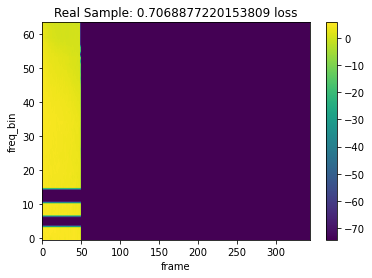

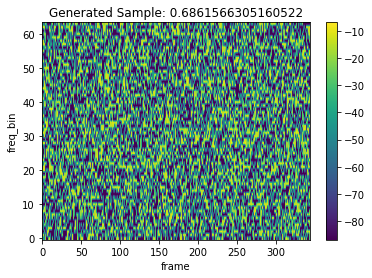

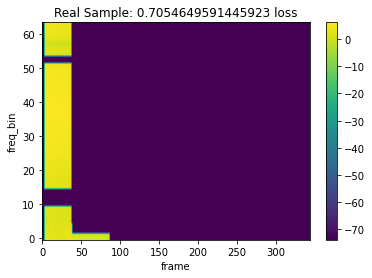

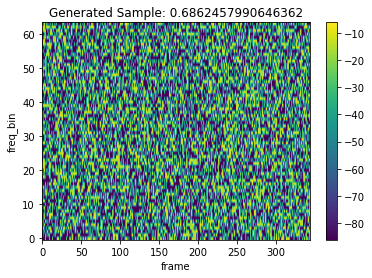

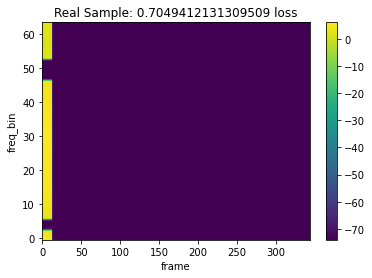

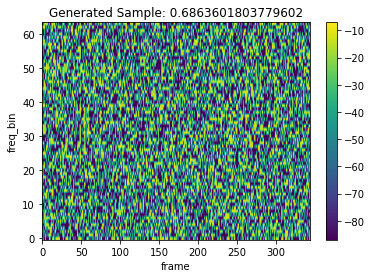

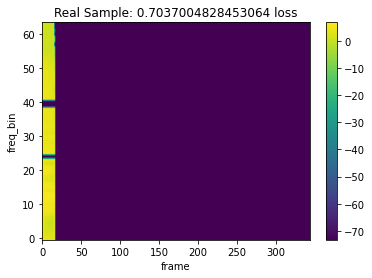

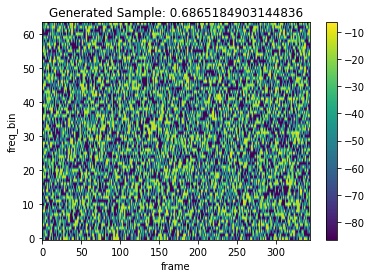

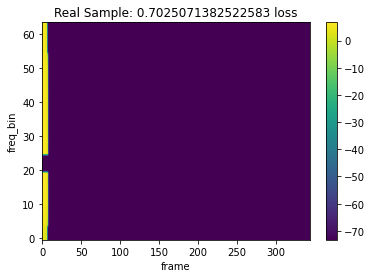

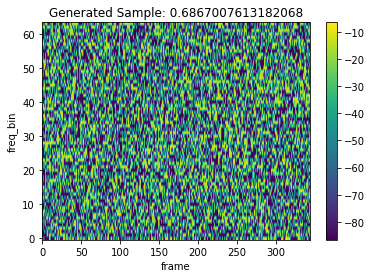

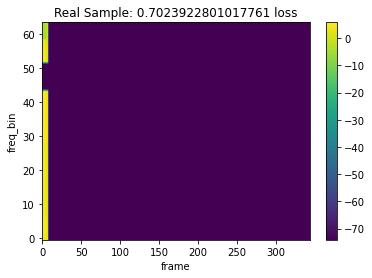

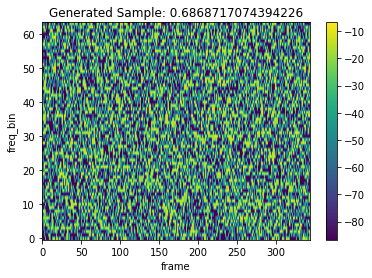

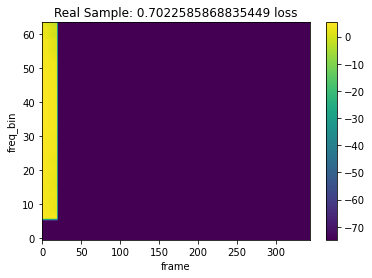

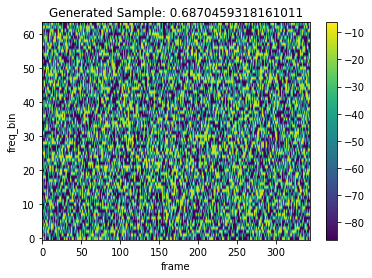

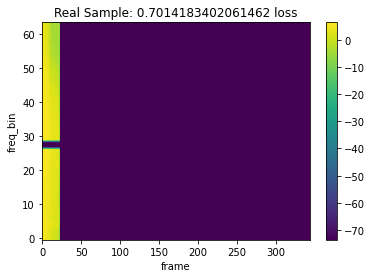

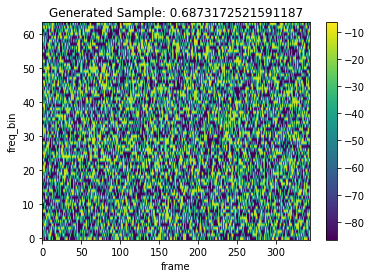

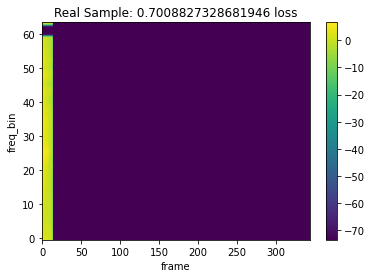

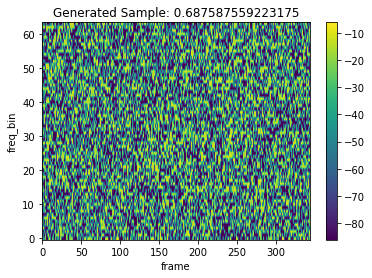

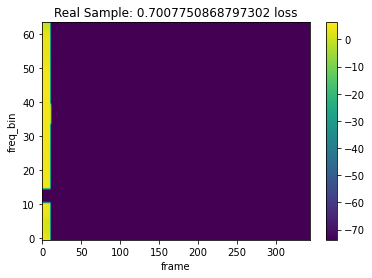

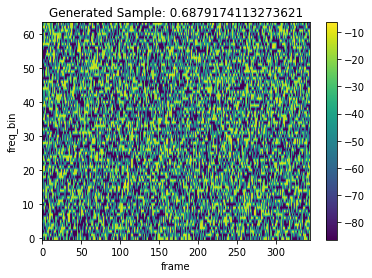

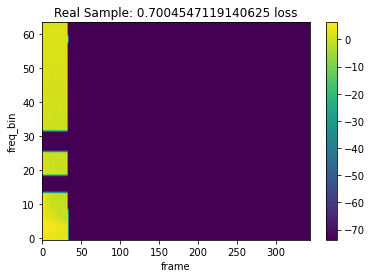

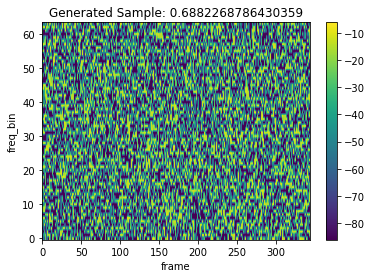

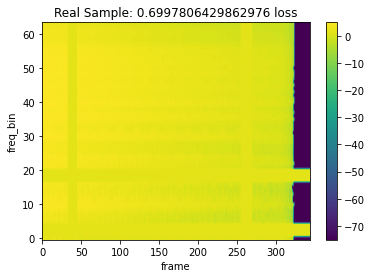

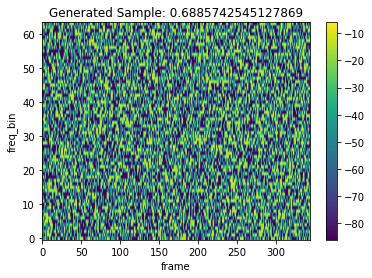

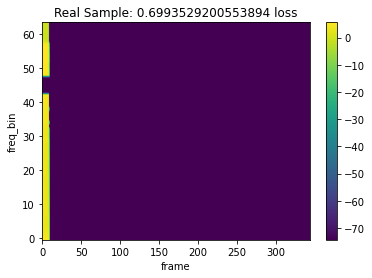

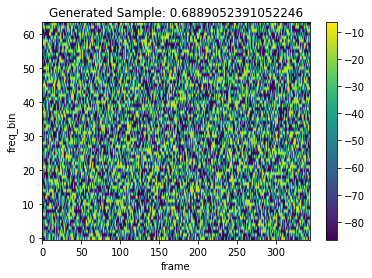

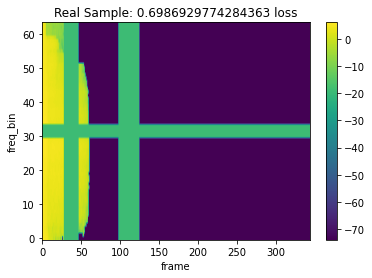

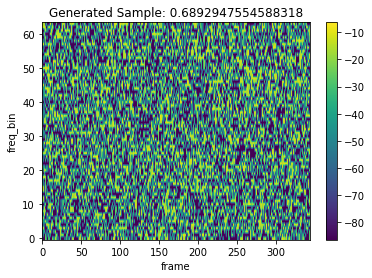

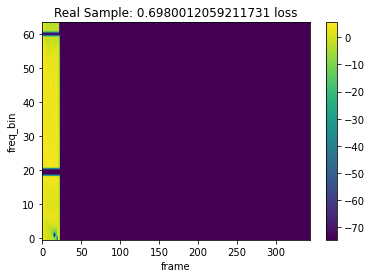

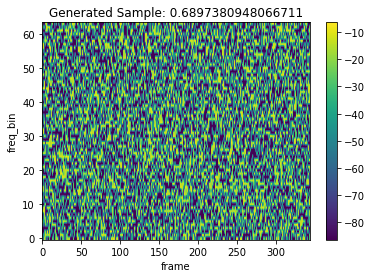

In [30]:
# Models

# Based on https://towardsdatascience.com/build-a-super-simple-gan-in-pytorch-54ba349920e4

# We need a generator that takes in noise
# and generates torch.Size([2, 64, 344])
# 2 = num_channels (this is `inputs` which the model is run on)
# 64 = Mel freq_bands
# 344 = time_steps

class generator(nn.Module):
    def __init__(self):
        super(generator, self).__init__()
        self.fc1 = nn.Linear(256, 1024)
        self.fc2 = nn.Linear(1024, 2048)
        self.fc3 = nn.Linear(2048, 44032)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)
        x = x.view(-1, 2, 64, 344)
        return nn.Tanh()(x)
    
# Load Data

df = pd.read_csv('data/edm_no_loops.csv')
df = df[['path', 'class']]
myds = SoundDS(df)
train_dl = torch.utils.data.DataLoader(myds, batch_size=64, shuffle=True)

# Start

num_epochs = 5
batch_size = 1
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
D_lr, G_lr, D_max_lr, G_max_lr = 2e-4, 3e-4, 1e-2, 2e-4

D = AudioClassifier()
D_optimizer = torch.optim.Adam(D.parameters(), lr=D_lr)
D_scheduler = torch.optim.lr_scheduler.OneCycleLR(D_optimizer, max_lr=D_max_lr, steps_per_epoch=int(len(train_dl)), epochs=num_epochs, anneal_strategy="linear")
# cp = torch.load('D:/Development/generative-beatpack/models/zesty-salad-125_e512_f3_b128.pt')
# D.load_state_dict(cp['model_state_dict'])
# D_optimizer.load_state_dict(cp['optimizer_state_dict'])
D.to(device)

G = generator()
G_optimizer = torch.optim.Adam(G.parameters(), lr=G_lr)
G_scheduler = torch.optim.lr_scheduler.OneCycleLR(G_optimizer, max_lr=G_max_lr, steps_per_epoch=int(len(train_dl)), epochs=num_epochs, anneal_strategy="linear")
# gcp = torch.load('./Generator_epoch_19.pth') # e 410
# G.load_state_dict(cp, strict=False)
G.to(device)

loss = nn.BCELoss()

with trange(num_epochs, unit="epoch") as tepoch:
    for epoch in tepoch:
        for idx, data in enumerate(train_dl):
            idx += 1
            
            # zero the gradients on each iteration
            
            # Generate examples of even real data
            true_data = data[0].to(device)
            inputs_m, inputs_s = true_data.mean(), true_data.std()
            true_data = (true_data - inputs_m) / inputs_s
            true_labels = torch.ones(true_data.shape[0], 10).to(device)
            
            # Train the Generator...
            noise = (torch.rand(true_data.shape[0], 256) - 0.5) / 0.5
            noise = noise.to(device)
            generated_data = G(noise)
            fake_label = torch.zeros(generated_data.shape[0], 10).to(device)
            G_optimizer.zero_grad()
            generator_discriminator_out = D(generated_data)
            generator_loss = loss(generator_discriminator_out, fake_label)
            generator_loss.backward()
            G_optimizer.step()
            G_scheduler.step()
            
            # Train the discriminator on true/generated data
            noise = (torch.rand(true_data.shape[0], 256) - 0.5) / 0.5
            noise = noise.to(device)
            D_optimizer.zero_grad()
            true_discriminator_out = D(true_data)
            fake_D_inputs = G(noise)
            fake_discriminator_out = D(fake_D_inputs)
            true_discriminator_loss = loss(true_discriminator_out, true_labels)
            generator_discriminator_loss = loss(fake_discriminator_out, fake_label)
            discriminator_loss = (true_discriminator_loss + generator_discriminator_loss) / 2
            discriminator_loss.backward()
            D_optimizer.step()
            D_scheduler.step()

            # if idx == len(train_dl): 
            real_sg = true_data.view(-1, 2, 64, 344)[0].cpu().detach().numpy()
            PlotSpectrogram(real_sg[0], title="Real Sample: "+str(true_discriminator_loss.item())+" loss")
            wav_data = librosa.feature.inverse.mel_to_audio(real_sg[0], sr=44100, n_fft=1024, hop_length=None)                
            with SoundFile('./output/real_'+str(epoch)+'_'+str(idx)+'.wav', 'w', 44100, 1, 'PCM_24') as f:
                f.write(wav_data)

            gen_sg = generated_data.view(-1, 2, 64, 344)[0].cpu().detach().numpy()
            PlotSpectrogram(gen_sg[0], title=f"Generated Sample: "+str(generator_loss.item())+"")
            wav_data = librosa.feature.inverse.mel_to_audio(gen_sg[0], sr=44100, n_fft=1024, hop_length=None)
            with SoundFile('./output/generated_'+str(epoch)+'_'+str(idx)+'.wav', 'w', 44100, 1, 'PCM_24') as f:
                f.write(wav_data)

            tepoch.set_postfix(batch=f"{idx}/{len(train_dl)}", epoch=f"{epoch}/{num_epochs}", D_loss=true_discriminator_loss.item(), G_loss=generator_loss.item())
            sleep(0.1)
            
    torch.save(G, '/models/gan/firstTest_e{}.pth'.format(epoch))
    print('Model saved.')